In [1]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from skopt import BayesSearchCV
#from fancyimpute import IterativeImputer
#from skopt import BayesSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
#read the data from the excel file
description = pd.read_excel('./E Commerce Dataset.xlsx', sheet_name='Data Dict', header=1, usecols=[1,2,3])
data = pd.read_excel('./E Commerce Dataset.xlsx', sheet_name='E Comm')


# Categorical Encoding

In [3]:
cat_data = data.select_dtypes(include='object')
cat_data

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
0,Mobile Phone,Debit Card,Female,Laptop & Accessory,Single
1,Phone,UPI,Male,Mobile,Single
2,Phone,Debit Card,Male,Mobile,Single
3,Phone,Debit Card,Male,Laptop & Accessory,Single
4,Phone,CC,Male,Mobile,Single
...,...,...,...,...,...
5625,Computer,Credit Card,Male,Laptop & Accessory,Married
5626,Mobile Phone,Credit Card,Male,Fashion,Married
5627,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
5628,Computer,Credit Card,Male,Laptop & Accessory,Married


In [4]:
#encode categorical variables and add it to the normal dataset
encoded = pd.get_dummies(cat_data,drop_first=True)

data_enc = pd.concat([data.drop(cat_data.columns, axis=1), encoded], axis=1)
data_enc.drop('CustomerID', axis=1,inplace=True)

In [5]:
data_enc

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,1,4.0,3,6.0,3.0,3,2,9,1,11.0,...,False,False,False,False,True,False,False,False,False,True
1,1,NaN,1,8.0,3.0,4,3,7,1,15.0,...,False,True,True,False,False,True,False,False,False,True
2,1,NaN,1,30.0,2.0,4,3,6,1,14.0,...,False,False,True,False,False,True,False,False,False,True
3,1,0.0,3,15.0,2.0,4,5,8,0,23.0,...,False,False,True,False,True,False,False,False,False,True
4,1,0.0,1,12.0,NaN,3,5,3,0,11.0,...,False,False,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,0,10.0,1,30.0,3.0,2,1,6,0,18.0,...,False,False,True,False,True,False,False,False,True,False
5626,0,13.0,1,13.0,3.0,5,5,6,0,16.0,...,False,False,True,False,False,False,False,False,True,False
5627,0,1.0,1,11.0,3.0,2,4,3,1,21.0,...,False,False,True,False,True,False,False,False,True,False
5628,0,23.0,3,9.0,4.0,5,4,4,0,15.0,...,False,False,True,False,True,False,False,False,True,False


# Model Development

In [6]:
#selecting features and target variable, and splitting the data
X=data_enc.drop(['Churn'],axis=1)
y=data_enc['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

#cross validation
skfcv=StratifiedKFold(n_splits=5)

In [7]:
#Build logistic regression pipeline
log_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                    ('logreg',LogisticRegression())])

#cross validate logistic regression model
print(f"Cross validation score for Logistic Regression: {np.mean(cross_val_score(log_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for Logistic Regression: 0.6311351312850835


Test score for Logistic Regression: 0.6409495548961425
Training score for Logistic Regression: 0.6497305619707467


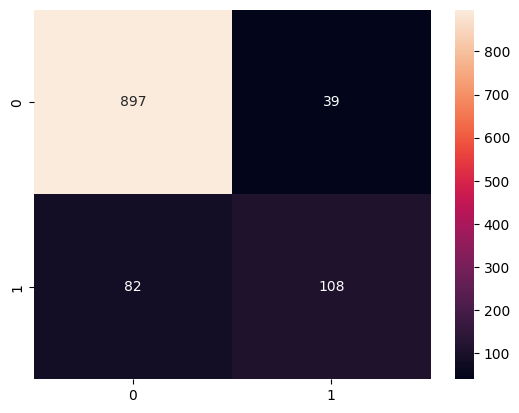

In [8]:
#use logistic regression pipeline to predict test sample
log_pipe.fit(X_train,y_train)
print(f"Test score for Logistic Regression: {f1_score(y_test, log_pipe.predict(X_test))}")
print(f"Training score for Logistic Regression: {f1_score(y_train, log_pipe.predict(X_train))}")
log_mat = confusion_matrix(y_test, log_pipe.predict(X_test))
sns.heatmap(log_mat, annot=True,fmt="g")
plt.show()

In [9]:
#Build LinearDiscriminantAnalysis pipeline
lda_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                    ('lda',LinearDiscriminantAnalysis())])

#cross validate LinearDiscriminantAnalysis model
print(f"Cross validation score for LinearDiscriminantAnalysis: {np.mean(cross_val_score(lda_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for LinearDiscriminantAnalysis: 0.5911106748453845


Test score for LinearDiscriminantAnalysis: 0.6358024691358025
Training score for LinearDiscriminantAnalysis: 0.609387430389817


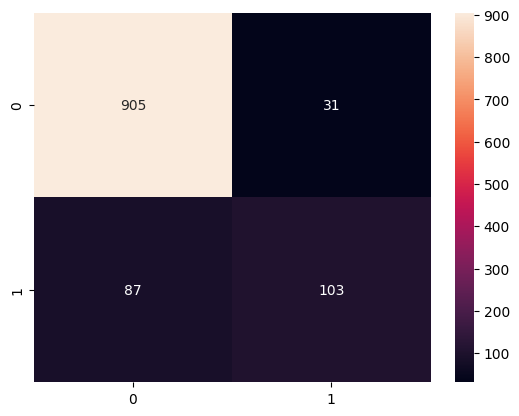

In [10]:
#use LinearDiscriminantAnalysis pipeline to predict test sample
lda_pipe.fit(X_train,y_train)
print(f"Test score for LinearDiscriminantAnalysis: {f1_score(y_test, lda_pipe.predict(X_test))}")
print(f"Training score for LinearDiscriminantAnalysis: {f1_score(y_train, lda_pipe.predict(X_train))}")
lda_mat = confusion_matrix(y_test, lda_pipe.predict(X_test))
sns.heatmap(lda_mat, annot=True,fmt="g")
plt.show()

In [11]:
#Build Random Forest pipeline
rf_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                    ('rfmodel',RandomForestClassifier())])

#cross validate Random Forest model
print(f"Cross validation score for Random Forest: {np.mean(cross_val_score(rf_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for Random Forest: 0.8594173356708048


Test score for Random Forest: 0.8895027624309392
Training score for Random Forest: 1.0


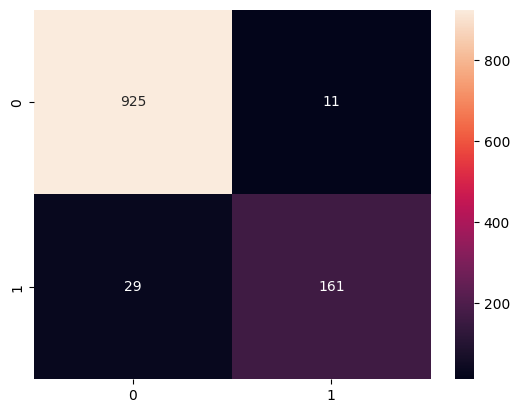

In [12]:
#use Random Forest pipeline to predict test and train sample
rf_pipe.fit(X_train,y_train)
print(f"Test score for Random Forest: {f1_score(y_test, rf_pipe.predict(X_test))}")
print(f"Training score for Random Forest: {f1_score(y_train, rf_pipe.predict(X_train))}")
rf_mat = confusion_matrix(y_test, rf_pipe.predict(X_test))
sns.heatmap(rf_mat, annot=True,fmt="g")
plt.show()

In [13]:
#Build XGBoost pipeline
xgb_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                    ('xgb',XGBClassifier(verbosity=0,use_label_encoder=False))])

#cross validate XGBoost model
print(f"Cross validation score for XGBoost: {np.mean(cross_val_score(xgb_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for XGBoost: 0.8911146143929061


Test score for XGBoost: 0.9157894736842105
Training score for XGBoost: 1.0


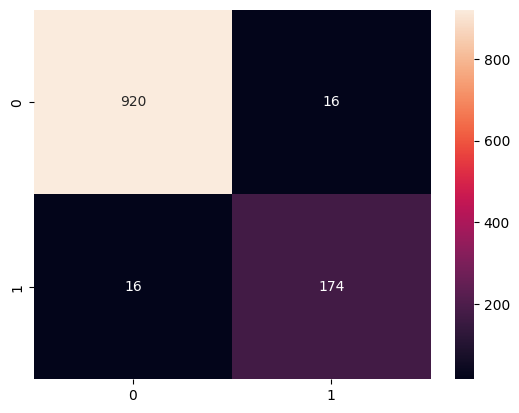

In [14]:
#use XGBoost pipeline to predict test and train sample
xgb_pipe.fit(X_train,y_train)
print(f"Test score for XGBoost: {f1_score(y_test, xgb_pipe.predict(X_test))}")
print(f"Training score for XGBoost: {f1_score(y_train, xgb_pipe.predict(X_train))}")
xgb_mat = confusion_matrix(y_test, xgb_pipe.predict(X_test))
sns.heatmap(xgb_mat, annot=True, fmt="g")
plt.show()

# HYPERPARAMETER TUNING

In [15]:
#create hyperparameter search space
space={'xgb__eta': (0.01,0.3),
       'xgb__max_depth': (5,11),
      'xgb__subsample': (0.4,1),
      'xgb__n_estimators': (100,250),
      'xgb__gamma':(0,5),
      'xgb__colsample_bytree':(0.4,1),
      'xgb__min_child_weight': (0.3,1)}

In [16]:
#create BayesSearchCV object
search=BayesSearchCV(xgb_pipe,search_spaces=space,n_jobs=-1,cv=skfcv, scoring='f1')

In [17]:
#fit the object to the data
search.fit(X_train, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=Pipeline(steps=[('imputer',
                                         IterativeImputer(random_state=0)),
                                        ('scaler', StandardScaler()),
                                        ('xgb',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       ena...
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       multi_strategy=None,
                                                       n_estimators=None,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       random_state=None, ...))]),
              n_jobs=-1, scoring='f1',
              search_spaces={'xgb__colsample_bytree': (0.4, 1),
                             'xgb__eta': (0.01, 0.3), 'xgb__gamma': (0, 5),
                             'xgb__max_depth': (5, 11),
                             'xgb__min_child_weight': (0.3, 1),
                             'xgb__n_estimators': (100, 250),
                             'xgb__subsample': (0.4, 1)})

In [18]:
#print the best cv score and the best parameters
print(search.best_score_)
print(search.best_params_)

0.9034213953079947
OrderedDict({'xgb__colsample_bytree': 1.0, 'xgb__eta': 0.16381382072657438, 'xgb__gamma': 0, 'xgb__max_depth': 8, 'xgb__min_child_weight': 0.3, 'xgb__n_estimators': 250, 'xgb__subsample': 0.7832031578184668})


0.9263157894736842


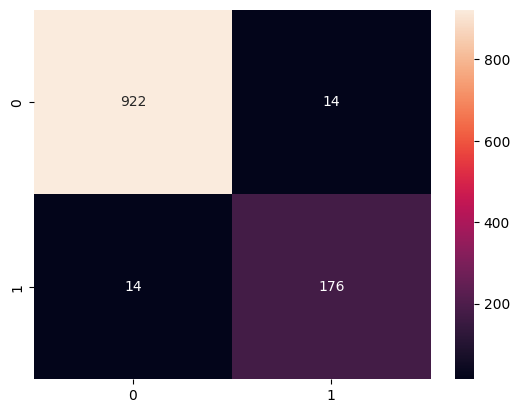

In [19]:
#use the best model parameters to predict the test sample and print the results
best_model=search.best_estimator_
print(f1_score(y_test,best_model.predict(X_test)))
sns.heatmap(confusion_matrix(y_test, best_model.predict(X_test)), annot=True, fmt="g")
plt.show()

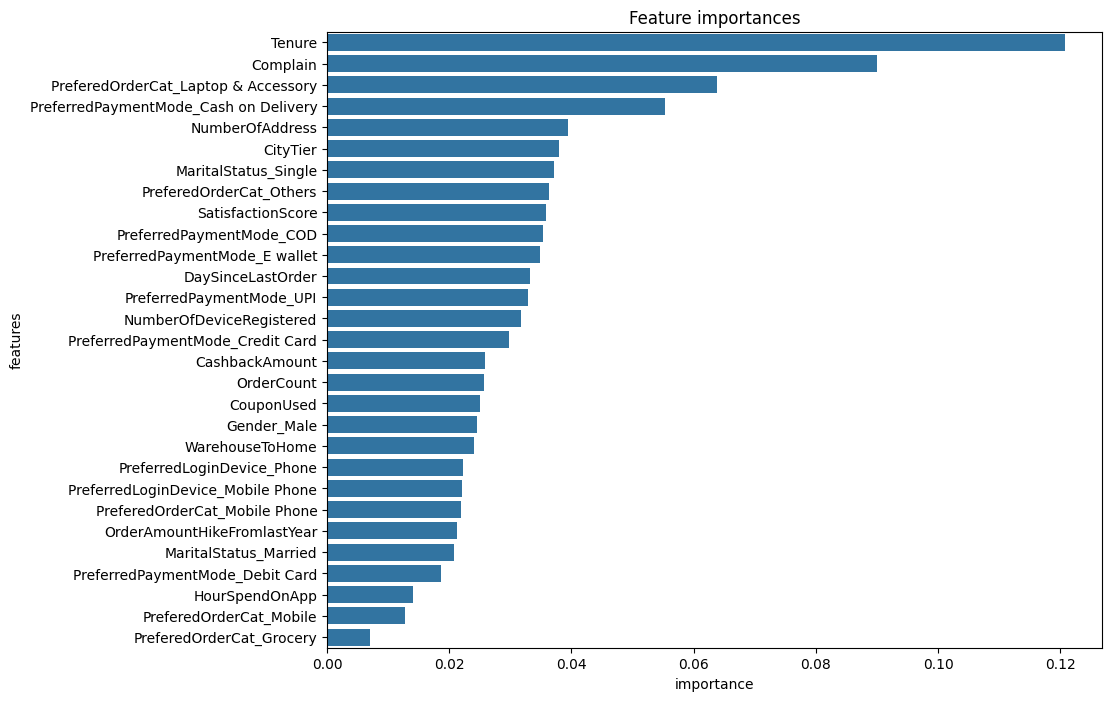

In [20]:
feature_importance=pd.DataFrame(search.best_estimator_[2].feature_importances_, columns=['importance'])
feature_importance['features'] = X_train.columns

plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='features', data=feature_importance.sort_values(by='importance', ascending=False))
plt.title('Feature importances')
plt.show()